In [2]:
import numpy as np
from matplotlib import pyplot as plt

from src.data import get_single_cifar10_dataloader as get_cifar10_dataloader

In [4]:
c10dl = get_cifar10_dataloader(target_class=4, batch_size=16, num_workers=1)[0]

Files already downloaded and verified
Files already downloaded and verified


In [22]:
def get_sample():
    for batch in c10dl:
        return batch[0]

In [23]:
sample_imgs = get_sample()

In [25]:
sample_imgs.shape

torch.Size([16, 3, 32, 32])

In [29]:
sample_imgs.min()

tensor(-1.)

In [30]:
sample_imgs.max()

tensor(1.)

In [31]:
def show_imgs(imgs):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.transpose((img+1)/2.0, (1, 2, 0)))
        plt.axis('off')
    plt.show()

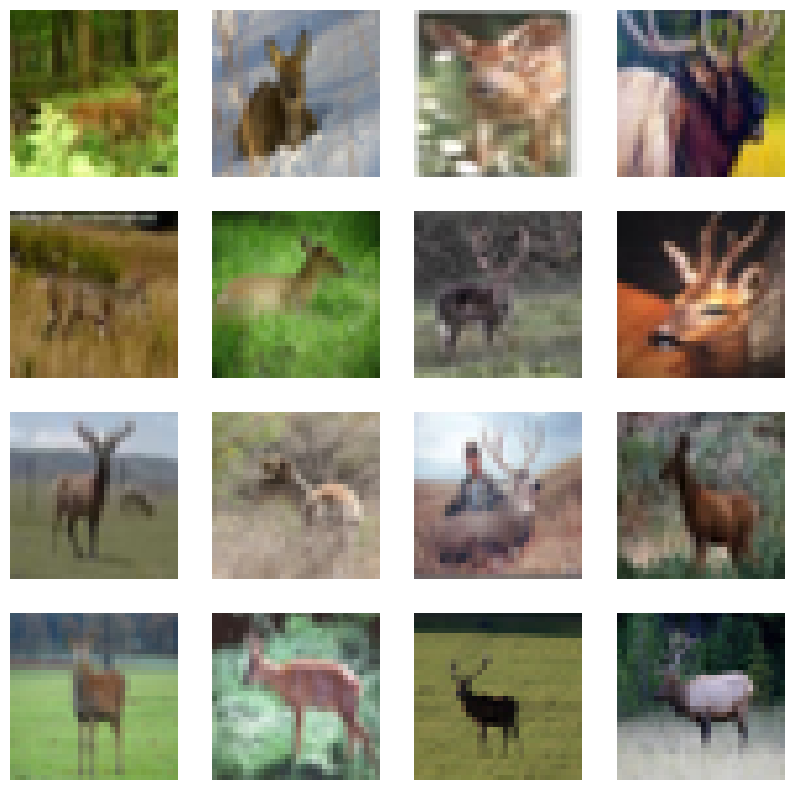

In [32]:
show_imgs(sample_imgs)

In [33]:
high_std_array = np.random.normal(loc=0.0, scale=10.0, size=(16, 3, 32, 32))
low_std_array = np.random.normal(loc=0.0, scale=0.1, size=(16, 3, 32, 32))

In [34]:
def calculate_diversity(input_tensor) -> float:
    return 0.0

In [35]:
def calculate_quality(input_tensor) -> float:
    return 0.0

## Testing the Code

### Image Diversity

This should return a high value since the noise array `high_std_array` has a high standard deviation

In [36]:
calculate_diversity(high_std_array)

0.0

This should return a **low** value since the noise array `low_std_array` has a low standard deviation

In [38]:
calculate_diversity(low_std_array)

0.0

This should return a value roughly between a tensor with very low standard deviation and very high standard deviation
because artificially generated noise with very high std should have a higher variety than real images but in comparison
to `low_std_array` it should be higher since the deers have _some_ variance.

In [39]:
calculate_diversity(sample_imgs)

0.0

### Image Quality

This should return a **high** value since the image quality of **real** images is high (basically "as good as it gets")

In [40]:
calculate_quality(sample_imgs)

0.0

This should return a **low** value since the image quality of noise poor (there is basically no real image features)

In [41]:
calculate_quality(low_std_array)

0.0